# Homography estimation via the DLT

Your name: Said Abdalrahim

Your ID number: 24177075

No we're going to read two images in, a left image and a right image. And we are going to estimate the homography between the two images, so that we can create an approsimate panorama. You know the panorama mode in your phone camera (or panorama app)? This is basically what that photo app does.

Let's start by reading the two images.

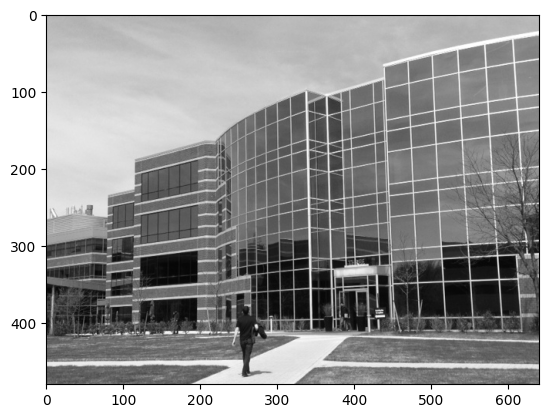

In [86]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

imgL = cv2.imread('building1.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(imgL,cmap='gray')

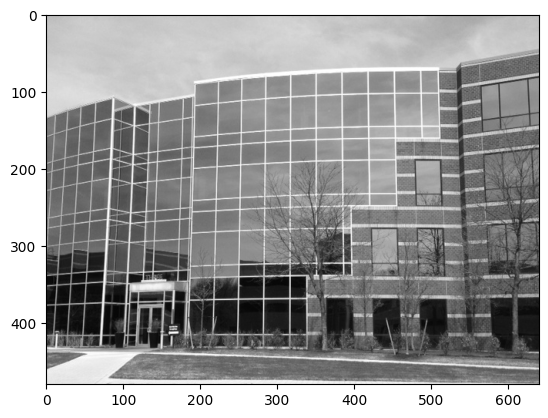

In [87]:
imgR = cv2.imread('building2.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(imgR,cmap='gray')

In previous vision modules, you will have covered feature matching. I don't expect you to repeat that here. So I will give you the code to match the two images using ORB. And we will match the features between the frames.

Minor change here: the orb detector is initialized to a value of 900, which seems to be suitable for our two cases of 40 and 80 feature matches here

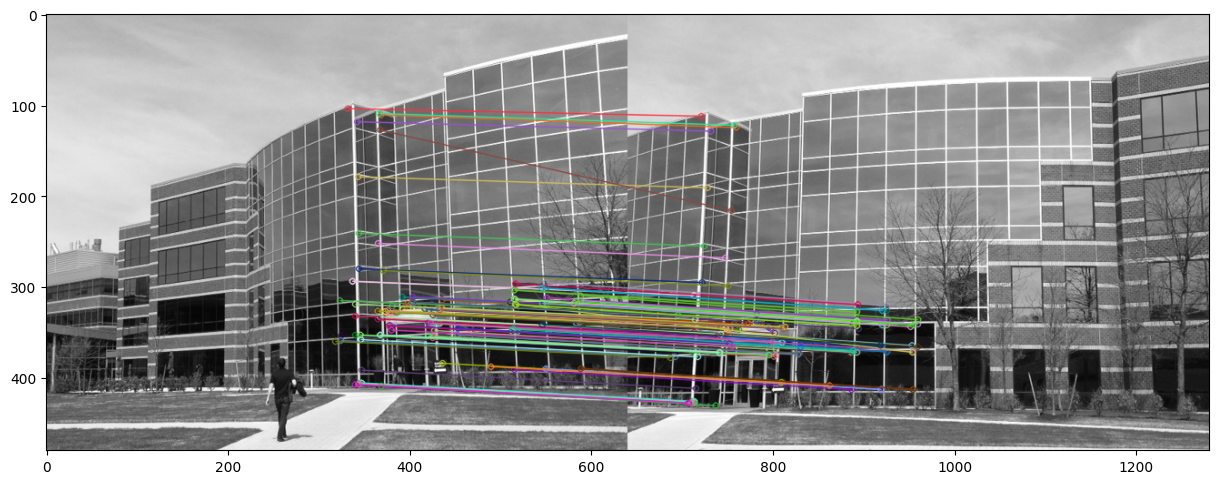

In [88]:
# Initiate ORB detector
orb = cv2.ORB_create(900)

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(imgL,None)
kp2, des2 = orb.detectAndCompute(imgR,None)
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(imgL,kp1,imgR,kp2,matches[:120],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (15,15)),plt.imshow(img3),plt.show();

So we can now see the features in each image (circles) and thei corresponding matches (lines). What can we say about it? It seems that there are a lot of good matches, but a few outliers as well.

## Direct Linear Transform

We're going to estimate the homography between the two images using the direct linear transform, as discussed in Lecture 3.3.

Recall that we do this by building our $\textbf{B}$ matrix, and then applying the SVD.
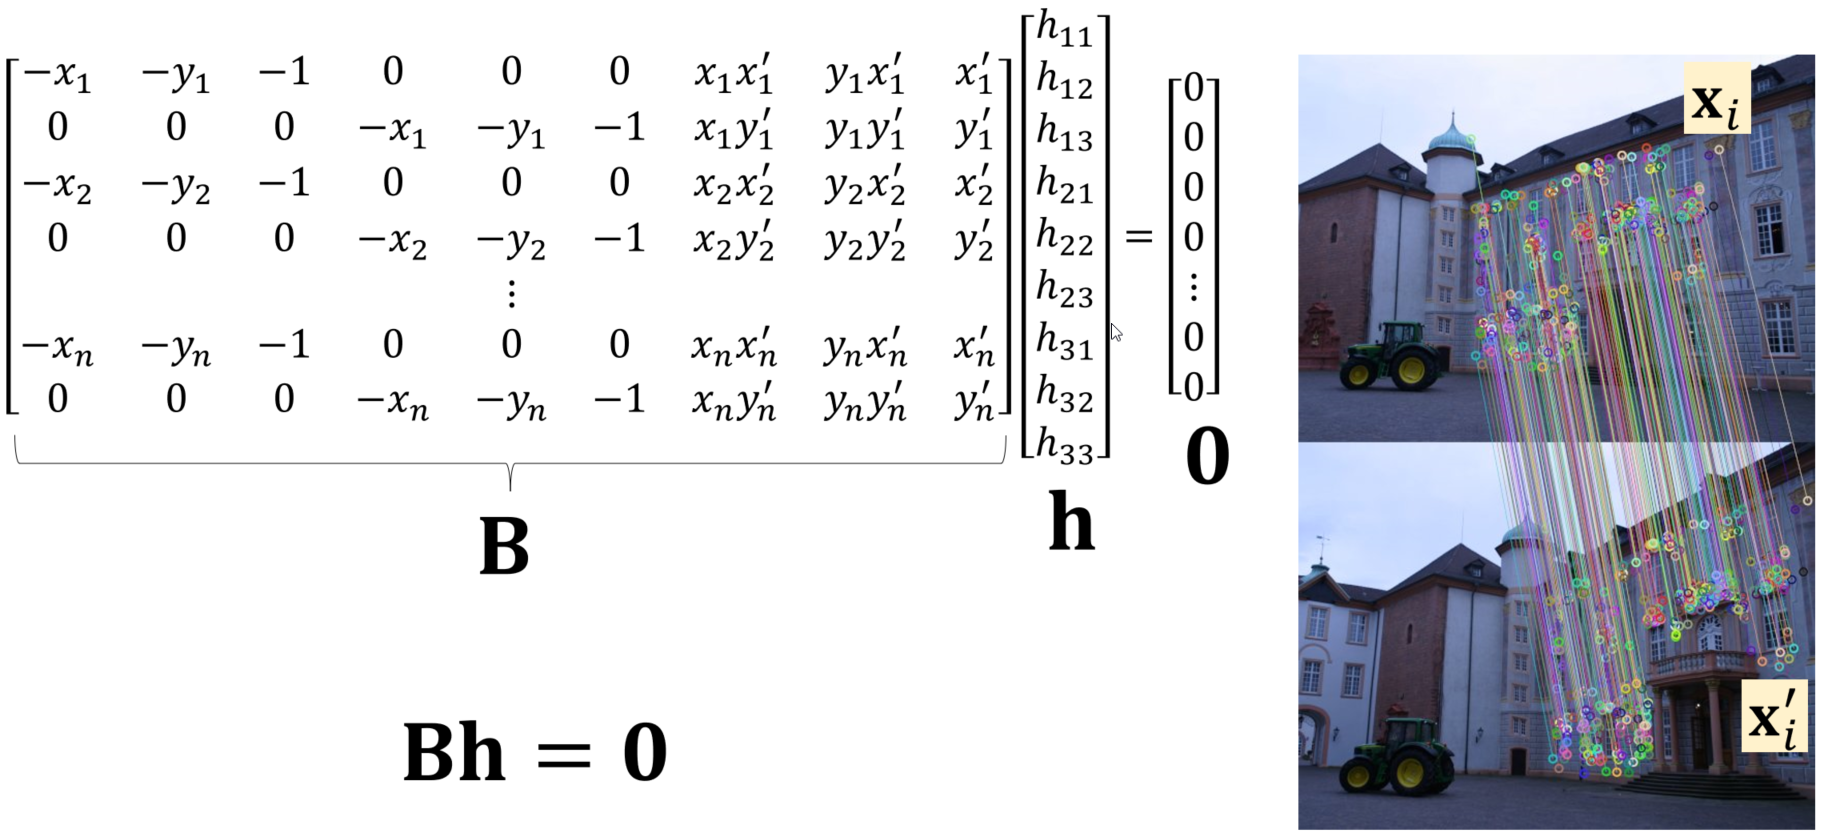

The full algorithm for estimating the homgraphy through the direct linear transform is given at the end of that lecture video:
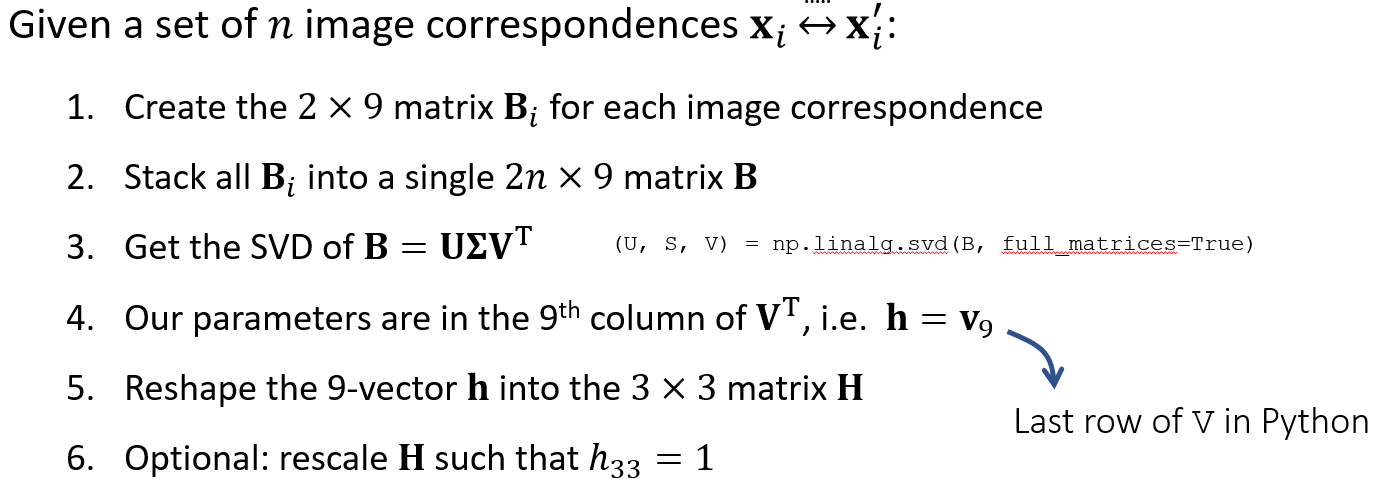

However, we know that the DLT is very susceptible to noise. So, for the moment, let's take the first 40 ORB matches, for now, and build the direct linear transform. In OpenCV, the sift matcher sorts the list of mathes by "goodness" of match. So, if we take just the first 40, we can be pretty sure that we won't get any outliers. Let's have a look.

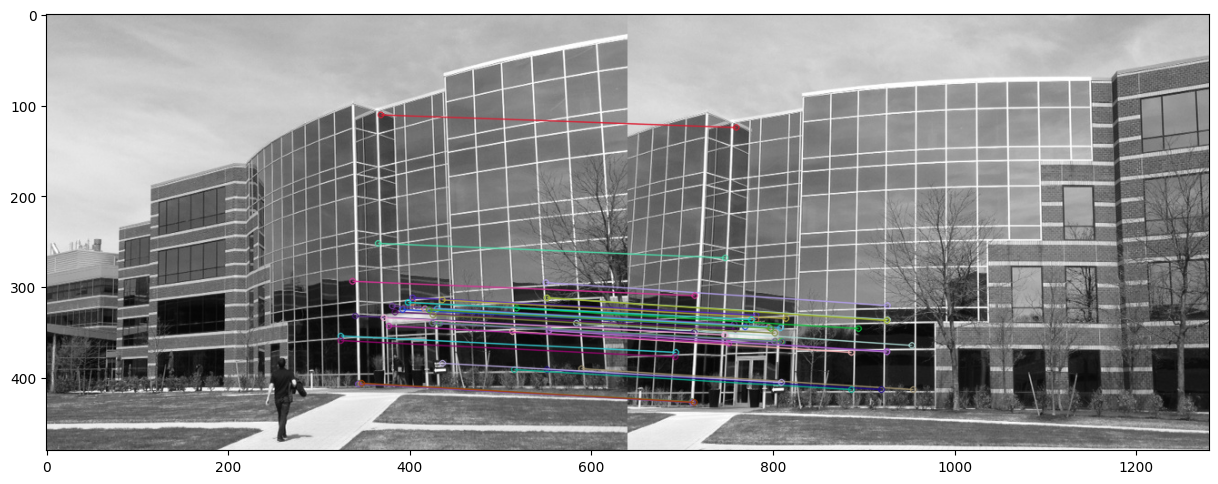

(<Figure size 1500x1500 with 1 Axes>,
 None)

In [89]:
# Draw first 40 matches.
number_of_matches = 40
img3 = cv2.drawMatches(imgL,kp1,imgR,kp2,matches[:number_of_matches],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (15,15)),plt.imshow(img3),plt.show()

Yep, these matches look very clean. Let's work with these for now. Later we will try adding sme feature that are outliers, to see what happens, but for now, go with these first forty features.

In [90]:
# Take the first forty features, which we are pretty happy are inliers.

# OpenCV is a little convoluted in how it manages the correspondences, so I 
# simplified it. In this code, I have reformatted the correspondence list 
# such that the left and right points at at corresponding locations in the 
# lists.

# that is, 
#      left_pts[0] <-> rght_pts[0]
#      left_pts[1] <-> rght_pts[1]
#         and so on

# left_pts = np.float32([kp1[m.queryIdx].pt for m in matches[:40]]).reshape(-1,2)
# rght_pts = np.float32([kp2[m.trainIdx].pt for m in matches[:40]]).reshape(-1,2)

<font color='blue'>
    
#### Task

Using the forty good features above, estimate the homography matrix using the DLT algorithm above.
    
Warp the right image according to the homography. I don't expect you to implement this yourself (though, if you did want to, it wouldn't be dissimilar to what you did in the last activity). Instead, I suggest we use the OpenCV [`cv2.warpPerspective`](https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87) function to do this.
    
Notes:
 * To build the $\mathbf{B}$ matrix, you might consider building the 2x9 sub-matrix $\mathbf{B}_i$ for each correspondence pair, and then stack the matrices ([`np.append`](https://numpy.org/doc/stable/reference/generated/numpy.append.html) setting `axis=0`)
 * In the lecture, I mention the command to run the [SVD](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html).
 * Use the [`np.reshape`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) command to convert the 9-vector to the 3x3-matrix
 * The homography estimation gives us the transform that maps points in the left image to points in the right image. However, we want to match the right image to the left image, so we should use the *inverse* of the homography.
 * `cv2.warpPerspective` takes three arguments: 1) the image to warp, 2) the matrix to use to do the warping, and 3) the size of the output image. For the size of the image, I suggest to set it to `(1000,imgL.shape[0])`. This is big enough to accomodate the generated panorama.

here first I defined a utility function for the homography matrix calculation and warping of the image, for ease of reading and reusability

In [91]:
##################
# Your code here
def estimate_homography_and_warp(imgL, imgR, kp1, kp2, matches, number_of_matches):
    """
    Estimate the homography matrix using the Direct Linear Transform (DLT) algorithm
    and warp the right image to the left image's perspective.

    Parameters:
    imgL (numpy.ndarray): The left image.
    imgR (numpy.ndarray): The right image.
    kp1 (tuple): Keypoints from the left image.
    kp2 (tuple): Keypoints from the right image.
    matches (list): List of matched keypoints.
    number_of_matches (int): Number of matches to use for homography estimation.

    Returns:
    numpy.ndarray: The warped image.
    """
    left_pts = np.float32([kp1[m.queryIdx].pt for m in matches[:number_of_matches]]).reshape(-1,2)
    rght_pts = np.float32([kp2[m.trainIdx].pt for m in matches[:number_of_matches]]).reshape(-1,2)
    
    # build the B matrix
    B = []
    for i in range(number_of_matches):
        x, y = left_pts[i]             
        x_prime, y_prime = rght_pts[i] 
        
        B.append([-x, -y, -1, 0, 0, 0, x * x_prime, y * x_prime, x_prime])
        B.append([0, 0, 0, -x, -y, -1, x * y_prime, y * y_prime, y_prime])

    B = np.array(B)
    # SVD
    U, S, Vt = np.linalg.svd(B, full_matrices=True)

    # get the params and reshape the Vt to a 3x3 matrix
    h = Vt[-1].reshape(3,3)

    # rescale to make h33 = 1
    h = h/h[2,2]

    # Compute the inverse of the homography matrix
    h_inv = np.linalg.inv(h)

    # Warp the right image to the left image's perspective
    imgW = cv2.warpPerspective(imgR, h_inv, (1000, imgL.shape[0]))

    # This piece puts the left image in the output image at the requisite place
    imgW[:,:imgL.shape[1]] = imgL
    
    return imgW


call the function with number of matches equal to 80

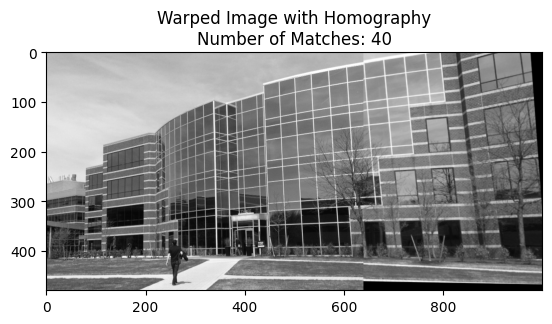

In [92]:
imgW = estimate_homography_and_warp(imgL, imgR, kp1, kp2, matches, number_of_matches)

plt.title(f'Warped Image with Homography\nNumber of Matches: {number_of_matches}')
plt.imshow(imgW, cmap='gray')

## Impact of outliers

Now let's see what happens when we add in some outliers. We'll take 80 of our features above. We start seeing some outliers creep in. What impact do these have on the DLT algorithm?

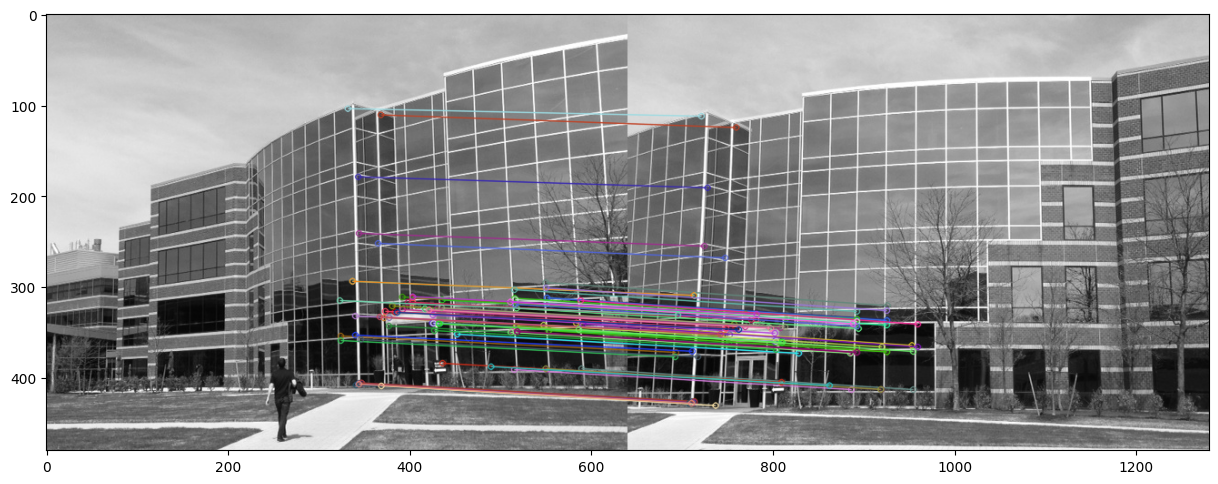

In [93]:
# Draw first 80 matches.
number_of_matches = 80
img3 = cv2.drawMatches(imgL,kp1,imgR,kp2,matches[:number_of_matches],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (15,15)),plt.imshow(img3),plt.show()

# Take the first 80 features, which we are pretty happy are inliers.
left_pts = np.float32([kp1[m.queryIdx].pt for m in matches[:number_of_matches]]).reshape(-1,2)
rght_pts = np.float32([kp2[m.trainIdx].pt for m in matches[:number_of_matches]]).reshape(-1,2)

<font color='blue'>

#### Task

The variables `left_pts` and `rght_pts` now contain 80 feature correspondences, which includes some outliers. Rerun (i.e., feel free to copy-paste the code from above) the DLT-based homography estimation that you wrote above, but using these 80 features.

calling the homography estimation and warping function with 80 matches and outliers

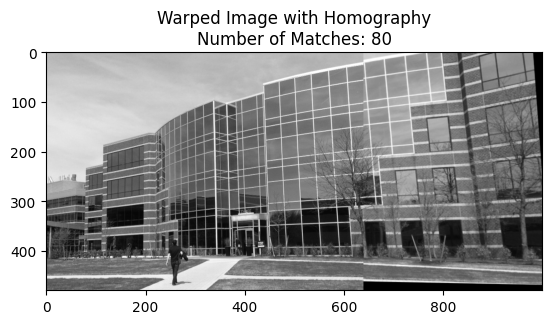

In [94]:
imgW = estimate_homography_and_warp(imgL, imgR, kp1, kp2, matches, number_of_matches)

plt.imshow(imgW, cmap='gray')
plt.title(f'Warped Image with Homography\nNumber of Matches: {number_of_matches}')
plt.show()

<font color='blue'>
    
##### Question: describe the impact of just the modest number of outlier?

The DLT algorithm is sensitive to outliers because it is a linear least squares method, this means that minimizes the error without considering incorrect correspondences.

this means that if there are a few incorrect points they can skew the homography matrix quite a bit because the outliers will have large residuals on the minimized squared errors.

As others have mentioned in the forums also in this implementation the ORB initialization value has a role to play, the default value which is 500 causes the 40 and 80 matches to be incorrect this is because it is not able to capture all the patterns in the scene, an implementation of 1000 gives good values for 40 and 80 matches but may not for different values.
